In [1]:
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search

import networkx as nx
import numpy
import pandas
import matplotlib

In [2]:
ELASTIC_SERVER_SOCKET = '192.168.56.101:9200'
elastic_client = Elasticsearch([ELASTIC_SERVER_SOCKET])

In [3]:
search = Search(using=elastic_client, index="bro-2017.11.29").filter('range', conn__id_resp_h={'gte': '192.168.0.0', 'lt': '192.168.255.255'})

In [4]:
client_ips = []
server_ips = []
for document in search.scan():
    try:
        client_ips.append(document.conn.id_orig_h)
        server_ips.append(document.conn.id_resp_h)
    except Exception as e:
        pass

In [5]:
# Since network connections have directionality, we use a directed grapgh. 
connection_graph = nx.DiGraph()

In [6]:
for client_ip, server_ip in zip(client_ips, server_ips):
    connection_graph.add_node(client_ip)
    connection_graph.add_node(server_ip)
    
    connection_graph.add_edge(client_ip, server_ip)

In [7]:
# PageRank tries to rank all nodes based on how well connected they are. 
# It gives more weight to nodes with more incoming connections. 
# This means that as an attacker moves laterally they will increase the score of the nodes further and fierther. 
# This demo was inspired by which https://github.com/JPCERTCC/LogonTracer also uses PageRank to hunt lateral movement 
pagerank_result = nx.pagerank(connection_graph)

In [8]:
pagerank_result_values = list(pagerank_result.values())

In [9]:
# We take the top 20% as our most interesting nodes. 
threshold = numpy.percentile(pagerank_result_values, 80)

In [11]:
# We color the bottom 80% blue and the top 20% red.
# A different approach that shades the based on score would likely be a nice upgrade. 
colors = []
for result in pagerank_result_values:
    if result >= threshold:
        colors.append('r')
    else:
        colors.append('b')        

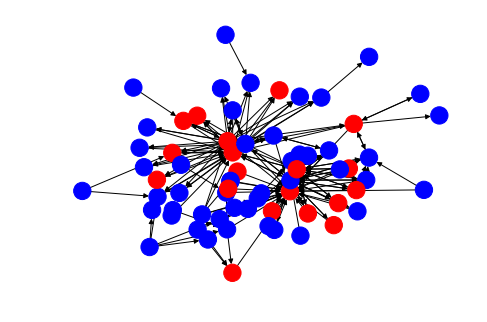

In [15]:
nx.draw_kamada_kawai(connection_graph, node_color=colors)
# We can see which nodes may be more interesting. 
# Nodes with a high PageRank score should be deeply familier to somone defending the networkor
# Exaples of nodes with expected high rank are domain controllers and file shares. 
# Anything not immidietly recongnizable should be reviewed for why the rank is so high. 